In [1]:
import itertools
import math
import struct

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics, preprocessing

pd.options.display.max_rows = 2000
pd.options.display.max_columns = 1000
pd.options.display.width = 1500

In [2]:
def read_idx(filename):
    with open(filename, "rb") as f:
        zero, data_type, dims = struct.unpack(">HBB", f.read(4))
        shape = tuple(struct.unpack(">I", f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)


train_data = read_idx("./train-images.idx3-ubyte")
train_label = read_idx("./train-labels.idx1-ubyte")
test_data = read_idx("./t10k-images.idx3-ubyte")
test_label = read_idx("./t10k-labels.idx1-ubyte")

## Naive Bayes - Discrete mode
---
### Function of discrete mode:
- The equation is $$\frac{\Pr(x|\theta) \Pr(\theta)}{\Pr(x)} = \underset{j}{\operatorname{argmax}} \frac{\sum_{i=0}^{783}\frac{x_i}{n_{ji}} \times \pi_{ji}}{\Pr(x)}$$
- $\pi_{ji}$ is the prior = $\Pr[y=j] ,\hspace{1cm} 0 \leq j \leq 9$

In [3]:
class NaiveBayes_Dis():
    def __init__(self, train_data, train_label):
        self.train_label = train_label
        # How many numbers of digit 0~9
        self.class_count = [0 for _ in range(10)]

        # pixel_data[digit][pixel][bins] with pseudo count
        self.pixel_data = [[[10**-5 for _ in range(32)]
                            for _ in range(28 * 28)] for _ in range(10)]
        self.__buildTrainingData(train_data)

    def mapping(self, value):
        """
        For discrete mode: map 0~255 to 0~31
        """
        if value == 255:
            return 31
        else:
            return math.floor(value / 255 * 32)

    def flatten(self, data):
        flatten_data = []
        for i in range(len(data)):
            flatten_data.append(
                [item for sublist in data[i] for item in sublist])
        return flatten_data

    def __buildTrainingData(self, data):
        """
        For discrete mode: parse training data and save to dis_pixel_data[digit][pixel][bin]
        """
        vec = np.vectorize(self.mapping)
        data = vec(data)
        # flatten_data
        flatten_data = self.flatten(data)
        # Build class_count and pixel_data
        # class_count[digit]
        # pixel_data[digit][pixel][bin]
        for i, image in enumerate(flatten_data, 0):
            self.class_count[self.train_label[i]] += 1
            for pixel in range(len(image)):
                self.pixel_data[self.train_label[i]][pixel][image[pixel]] += 1

    def scale(self, posterior):
        posterior = preprocessing.minmax_scale(posterior)
        posterior = [i / posterior.sum() for i in posterior]
        return posterior

    def predict(self, test_data, test_label):
        vec = np.vectorize(self.mapping)
        test_data = vec(test_data)
        flatten_test_data = self.flatten(test_data)
        posterior = [np.zeros(10) for _ in range(len(flatten_test_data))]
        predict = []
        for i, img in enumerate(flatten_test_data, 0):
            for num in range(10):
                for pixel in range(784):
                    posterior[i][num] += np.log(
                        self.pixel_data[num][pixel][img[pixel]] /
                        self.class_count[num])
                posterior[i][num] += np.log(self.class_count[num] / 60000)
            predict.append(np.argmax(posterior[i]))
        scaled_posterior = []
        for post in posterior:
            scaled_posterior.append(self.scale(post))
        return scaled_posterior, predict

### Discrete mode: accuracy evaluate and guess


In [4]:
dis_result = NaiveBayes_Dis(train_data, train_label)
dis_post, dis_pred = dis_result.predict(test_data, test_label)

In [5]:
def discrete_output():
    # test cases
    for index in [0, 87, 456]:
        print("Posterior (in log scale):")
        for i in range(10):
            print("%d: %f" % (i, dis_post[index][i]))
        print("Prediction: %d, Ans: %d" % (dis_pred[index], test_label[index]))
        print("")
    acc = metrics.accuracy_score(test_label, dis_pred)
    print("Accuracy: %f\nError rate: %f" % (acc, 1 - acc))


discrete_output()

Posterior (in log scale):
0: 0.065078
1: 0.000000
2: 0.076065
3: 0.109349
4: 0.126210
5: 0.121189
6: 0.025718
7: 0.193801
8: 0.120319
9: 0.162271
Prediction: 7, Ans: 7

Posterior (in log scale):
0: 0.102270
1: 0.000000
2: 0.103122
3: 0.135248
4: 0.116805
5: 0.129428
6: 0.106576
7: 0.103965
8: 0.112554
9: 0.090032
Prediction: 3, Ans: 3

Posterior (in log scale):
0: 0.041650
1: 0.111371
2: 0.143103
3: 0.147952
4: 0.100479
5: 0.140278
6: 0.092488
7: 0.000000
8: 0.140389
9: 0.082290
Prediction: 3, Ans: 2

Accuracy: 0.850700
Error rate: 0.149300


In [7]:
def discrete_guess():
    guess = []
    for digit, pixel_bin in enumerate(dis_result.pixel_data, 1):
        digit = []
        for bins in pixel_bin:
            digit.append(int(sum(bins[0:16]) <= sum(bins[16:])))
        digit = np.reshape(digit, (28, 28))
        guess.append(digit)
    return guess


discrete_guess = discrete_guess()
guess_num = 3
print("Guess %d\n" % guess_num, pd.DataFrame(discrete_guess[guess_num]))

Guess 3
     0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27
0    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
1    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
2    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
3    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
4    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
5    0   0   0   0   0   0   0   0   0   0   0   0   1   1   1   1   1   0   0   0   0   0   0   0   0   0   0   0
6    0   0   0   0   0   0   0   0   0   0   1   1   1   1   1   1   1   1   0   0   0   0   0   0   0   0   0   0
7    0   0   0   0   0   0   0   0   0   0   0   1   1   1   1   1   1 

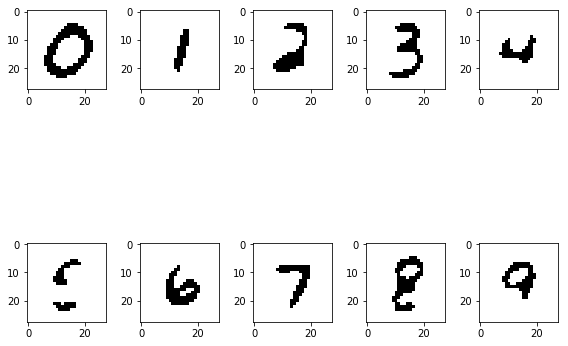

In [8]:
fig = plt.figure(figsize=(8, 8))
for num in range(10):
    sub = fig.add_subplot(2, 5, num + 1)
    sub.imshow(discrete_guess[num], cmap="Greys")
plt.tight_layout()
plt.show()

## Naive Bayes - Continuous mode
---